In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


Does supermarket accessibility differ across U.S. county income groups in 2015 and 2019?

In [2]:
##################### READ IN DATA

df2019 = pd.read_csv(r'C:\Users\GabeH\Desktop\DataFest Fall 2025\Food Access Research Atlas.csv')
df2015 = pd.read_csv(r'C:\Users\GabeH\Desktop\DataFest Fall 2025\FoodAccessResearchAtlasData2015.csv')

#County values must be equal to group by county
df2015['County'] = df2015['County'].astype(str)
df2019['County'] = df2019['County'].astype(str)
df2019['County'] = df2019['County'].str.replace(' County', '', regex=False)
df2015 = df2015[df2015['County'].isin(df2019['County'])]

###read in USDA food atlas environment data supplemental 

files1 = ["2025-food-environment-insecurity-data.csv", "2025-food-environment-restaurants-data.csv", "2025-food-environment-stores-data.csv"]
rows1 = [pd.read_csv(f, header=0) for f in files1]


df1 = rows1[0]
# Merge the remaining ones on 'County'
for r in rows1[1:]:
    df1 = pd.merge(df1, r, on='County', how='outer') 

files2 = ["FoodEnvironmentAtlasInsecurity2020.csv", "FoodEnvironmentAtlasRestaurants2020.csv", "FoodEnvironmentAtlasStores2020.csv"]
rows2 = [pd.read_csv(f, header = 0) for f in files2]
df2 = rows2[0]
for r in rows2[1:]:
    df2 = pd.merge(df2, r, on="County",how = 'outer') ###Horizontally merges the data, not the same as pd.concat on an axis

df1 = df1.groupby('County', as_index=False).first()
df2 = df2.groupby('County', as_index=False).first()

### Features we are interested in
# Household food insecurity (%, three-year average) 2015-17*, very low food insecurity, Full-service restaurants/1000 population proportion,
##Fast-food restaurants/1,000 pop 2016, convenience stores/1000 population, grocery stores/1000 population

df2019_ew = df1[["County", "FOODINSEC_18_20", "VLFOODSEC_18_20", "FSRPTH20", "FFRPTH20", "CONVSPTH20", "GROCPTH20"]]
df2015_ew = df2[["County", "FOODINSEC_15_17", "VLFOODSEC_15_17", "FSRPTH16", "FFRPTH16", "CONVSPTH16", "GROCPTH16"]]



In [3]:
#Group by important features and compute weighted mean by population for continuous features
df2019_w = (
    df2019.groupby("County").apply(
        lambda g: pd.Series({
            "MedianFamilyIncome": np.average(g["MedianFamilyIncome"], weights=g["Pop2010"]),
            "PovertyRate": np.average(g["PovertyRate"], weights=g["Pop2010"]),
            "lapop1": np.average(g["lapop1"], weights=g['Pop2010']), #Population count beyond 1 mile from supermarket
            "lahunv1": np.average(g["lahunv1"], weights = g["Pop2010"]),   #Housing units without vehicle count beyond 1 mile from supermarket
            "lasnap1": np.average(g["lasnap1"], weights = g["Pop2010"]), #Housing units receiving SNAP benefits count beyond 1 mile from supermarket
            'lalowi1': np.average(g["lalowi1"], weights = g["Pop2010"]) #Low income population count beyond 1 mile from supermarket
        })
    ).reset_index()
)


df2015_w = (
    df2015.groupby("County").apply(
        lambda g: pd.Series({
            "MedianFamilyIncome": np.average(g["MedianFamilyIncome"], weights=g["POP2010"]),
            "PovertyRate": np.average(g["PovertyRate"], weights=g["POP2010"]),
            "lapop1": np.average(g["lapop1"], weights=g['POP2010']),
            "lahunv1": np.average(g["lahunv1"], weights = g["POP2010"]),
            "lasnap1": np.average(g["lasnap1"], weights = g["POP2010"]),
            'lalowi1': np.average(g["lalowi1"], weights = g["POP2010"])
        })
    ).reset_index()
)

C:\Users\GabeH\AppData\Local\Temp\ipykernel_86032\1836742399.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2019.groupby("County").apply(
C:\Users\GabeH\AppData\Local\Temp\ipykernel_86032\1836742399.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2015.groupby("County").apply(


In [4]:
################    DIVIDE Data into QUARTILES based on income
df2019_w['IncomeGroup'] = pd.qcut(df2019_w['MedianFamilyIncome'], q=4, labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High'])
df2015_w['IncomeGroup'] = pd.qcut(df2015_w['MedianFamilyIncome'], q=4, labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High'])

low_Incomedf19 = df2019_w[df2019_w['IncomeGroup'] == 'Low']
low_MidIncomedf19 = df2019_w[df2019_w['IncomeGroup'] == 'Lower-Middle']
upp_MidIncomedf19 = df2019_w[df2019_w['IncomeGroup'] == 'Upper-Middle']
high_Incomedf19 = df2019_w[df2019_w['IncomeGroup'] == 'High']


low_Incomedf15 = df2015_w[df2015_w['IncomeGroup'] == 'Low']
low_MidIncomedf15 = df2015_w[df2015_w['IncomeGroup'] == 'Lower-Middle']
upp_MidIncomedf15 = df2015_w[df2015_w['IncomeGroup'] == 'Upper-Middle']
high_Incomedf15 = df2015_w[df2015_w['IncomeGroup'] == 'High']


d2015 = {
    "Low" : low_Incomedf15,
    "LM": low_MidIncomedf15,
    "UM": upp_MidIncomedf15,
    "High": high_Incomedf15
}

d2019 = {
     "Low" : low_Incomedf19,
     "LM": low_MidIncomedf19,
     "UM": upp_MidIncomedf19,
     "High": high_Incomedf19
}

In [5]:

################# MERGING THE ENVIRONMENTAL AND ATLAS DATASET by county

df2015_ew = df2015_ew[df2015_ew["County"].isin(df2015_w['County'])] 
df2015_m = pd.merge(df2015_w,df2015_ew, on = "County", how = "outer")

df2019_ew = df2019_ew[df2019_ew["County"].isin(df2019_w['County'])]
df2019_m = pd.merge(df2019_w,df2019_ew, on = "County", how = "outer")


df2019_m = df2019_m.replace(-9999, np.nan) #replace placeholders with nulls
df2015_m = df2015_m.replace(-9999, np.nan)

################## Handling null values - IMPUTE NaN values with the median of the feature at that feature

numeric_cols19 = df2019_m.select_dtypes(include='number').columns
numeric_cols15 = df2015_m.select_dtypes(include='number').columns
for col in numeric_cols19:
    df2019_m[col] = df2019_m[col].fillna(df2019_m[col].median())

for col in numeric_cols15:
    df2015_m[col] = df2015_m[col].fillna(df2015_m[col].median())

##### If one row had some null value that turned the IncomeGroup to null when grouping by county,
# go in and change that NaN value manually based on what the MedianFamilyIncome value is
df2019_m = df2019_m.copy()
for i, row in df2019_m.iterrows():

    # only process missing IncomeGroup values
    if pd.isna(row['IncomeGroup']):

        income = row['MedianFamilyIncome']

        # LOW
        if (income >= d2019['Low']['MedianFamilyIncome'].min()) and \
           (income <= d2019['Low']['MedianFamilyIncome'].max()):
            df2019_m.at[i, 'IncomeGroup'] = "Low"

        # LOWER-MIDDLE
        elif (income >= d2019['LM']['MedianFamilyIncome'].min()) and \
             (income <= d2019['LM']['MedianFamilyIncome'].max()):
            df2019_m.at[i, 'IncomeGroup'] = "Lower-Middle"

        # UPPER-MIDDLE
        elif (income >= d2019['UM']['MedianFamilyIncome'].min()) and \
             (income <= d2019['UM']['MedianFamilyIncome'].max()):
            df2019_m.at[i, 'IncomeGroup'] = "Upper-Middle"

        # HIGH
        elif (income >= d2019['High']['MedianFamilyIncome'].min()) and \
             (income <= d2019['High']['MedianFamilyIncome'].max()):
            df2019_m.at[i, 'IncomeGroup'] = "High"

In [7]:
## Create a new csv with the cleaned, merged datasets
dfclean19 = pd.read_csv(r'C:\Users\GabeH\Desktop\DataFest Fall 2025\2019.csv') #Shape = (1877, 18)
dfclean15 = pd.read_csv(r'C:\Users\GabeH\Desktop\DataFest Fall 2025\2015.csv')#Shape = (1742, 18)

dropl15 = ['lapophalf', 'lahunvhalf', 'lasnaphalf', 'lalowihalf', 'CONVSPTH16'] 
dropl19 = ['lapophalf', 'lahunvhalf', 'lasnaphalf', 'lalowihalf', 'CONVSPTH20']
dfclean19 = dfclean19.drop(dropl19, axis = 1)
dfclean15 = dfclean15.drop(dropl15, axis = 1)

################## FEATURES TO USE IN THE PCA EXCLUDING CATEGORICAL VARIABLES
fList19 = [['County', 'MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1',
            'lalowi1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20', 'IncomeGroup']]

fList15 = [['County', 'MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1',
            'lalowi1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'CONVSPTH16', 'GROCPTH16', 'IncomeGroup']]

#Create dataframes split by income group for PCA on each one

dfclean19low = dfclean19[dfclean19['IncomeGroup'] == 'Low']
dfclean19lm = dfclean19[dfclean19['IncomeGroup'] == 'Lower-Middle']
dfclean19um = dfclean19[dfclean19['IncomeGroup'] == 'Upper-Middle']
dfclean19h = dfclean19[dfclean19['IncomeGroup'] == 'High']

dfclean15low = dfclean15[dfclean15['IncomeGroup'] == 'Low']
dfclean15lm = dfclean15[dfclean15['IncomeGroup'] == 'Lower-Middle']
dfclean15um = dfclean15[dfclean15['IncomeGroup'] == 'Upper-Middle']
dfclean15h = dfclean15[dfclean15['IncomeGroup'] == 'High']

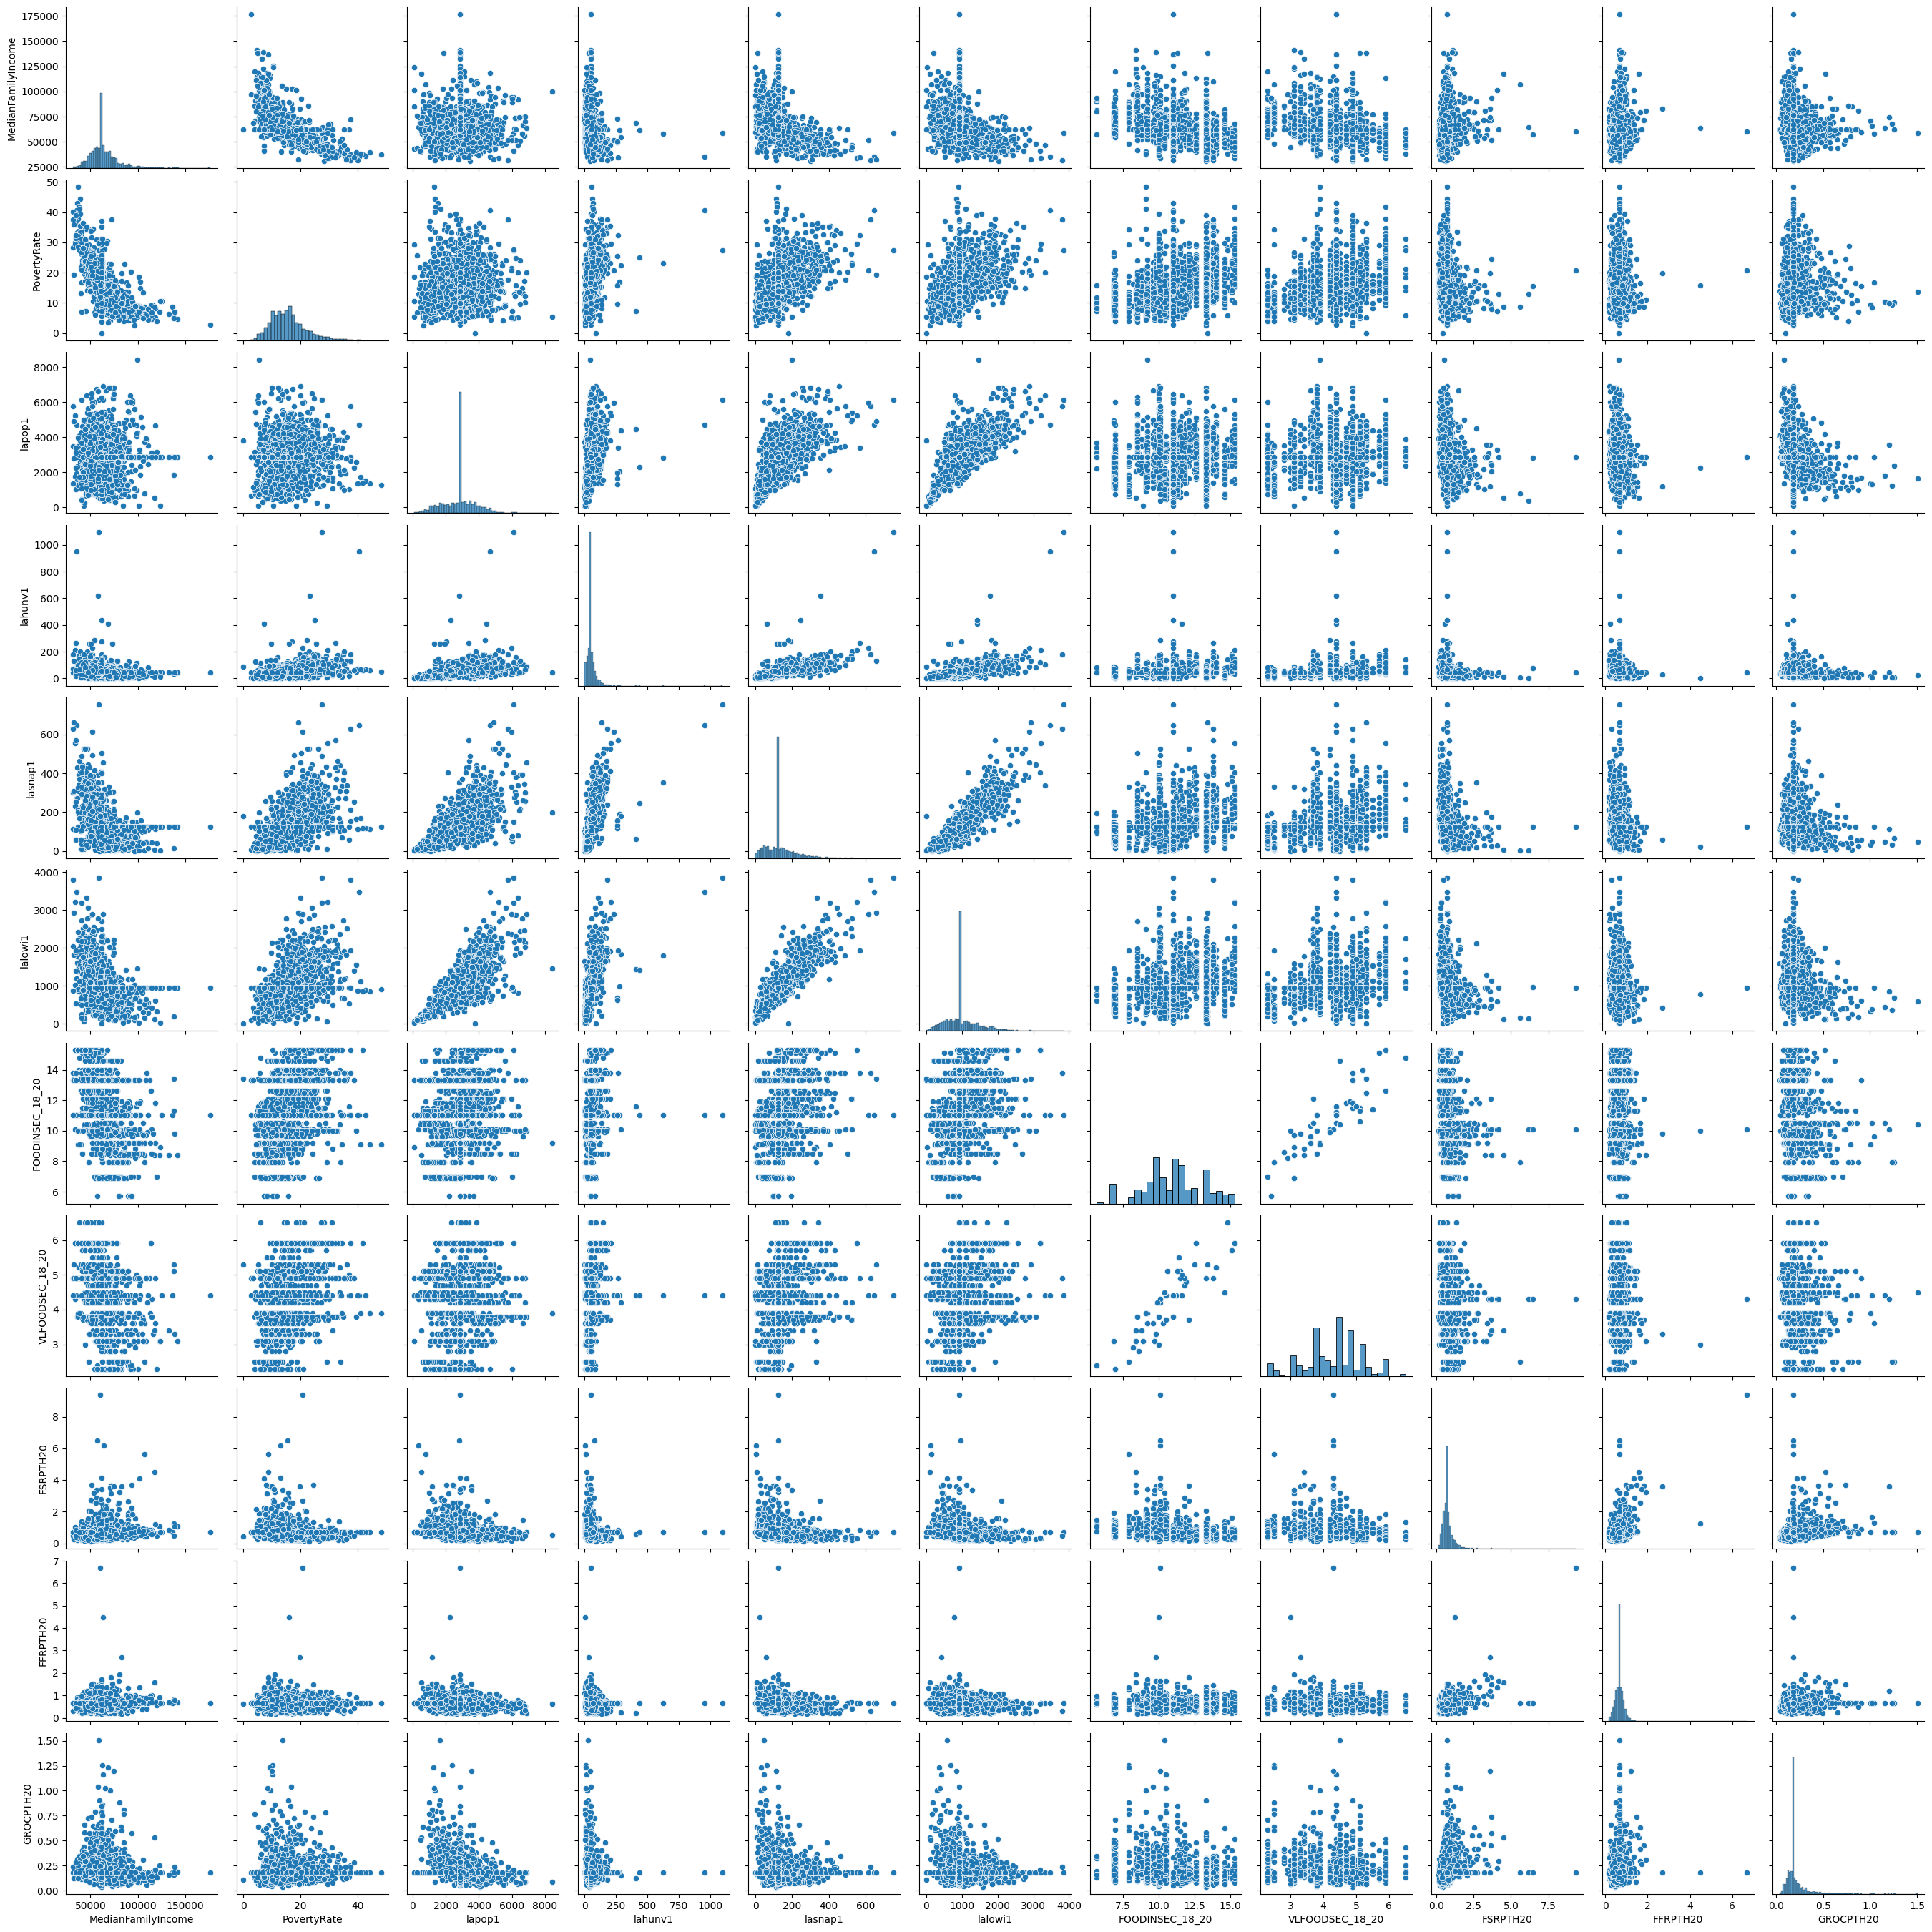

In [10]:
#Pairplot for 2019
sns.pairplot(dfclean19)

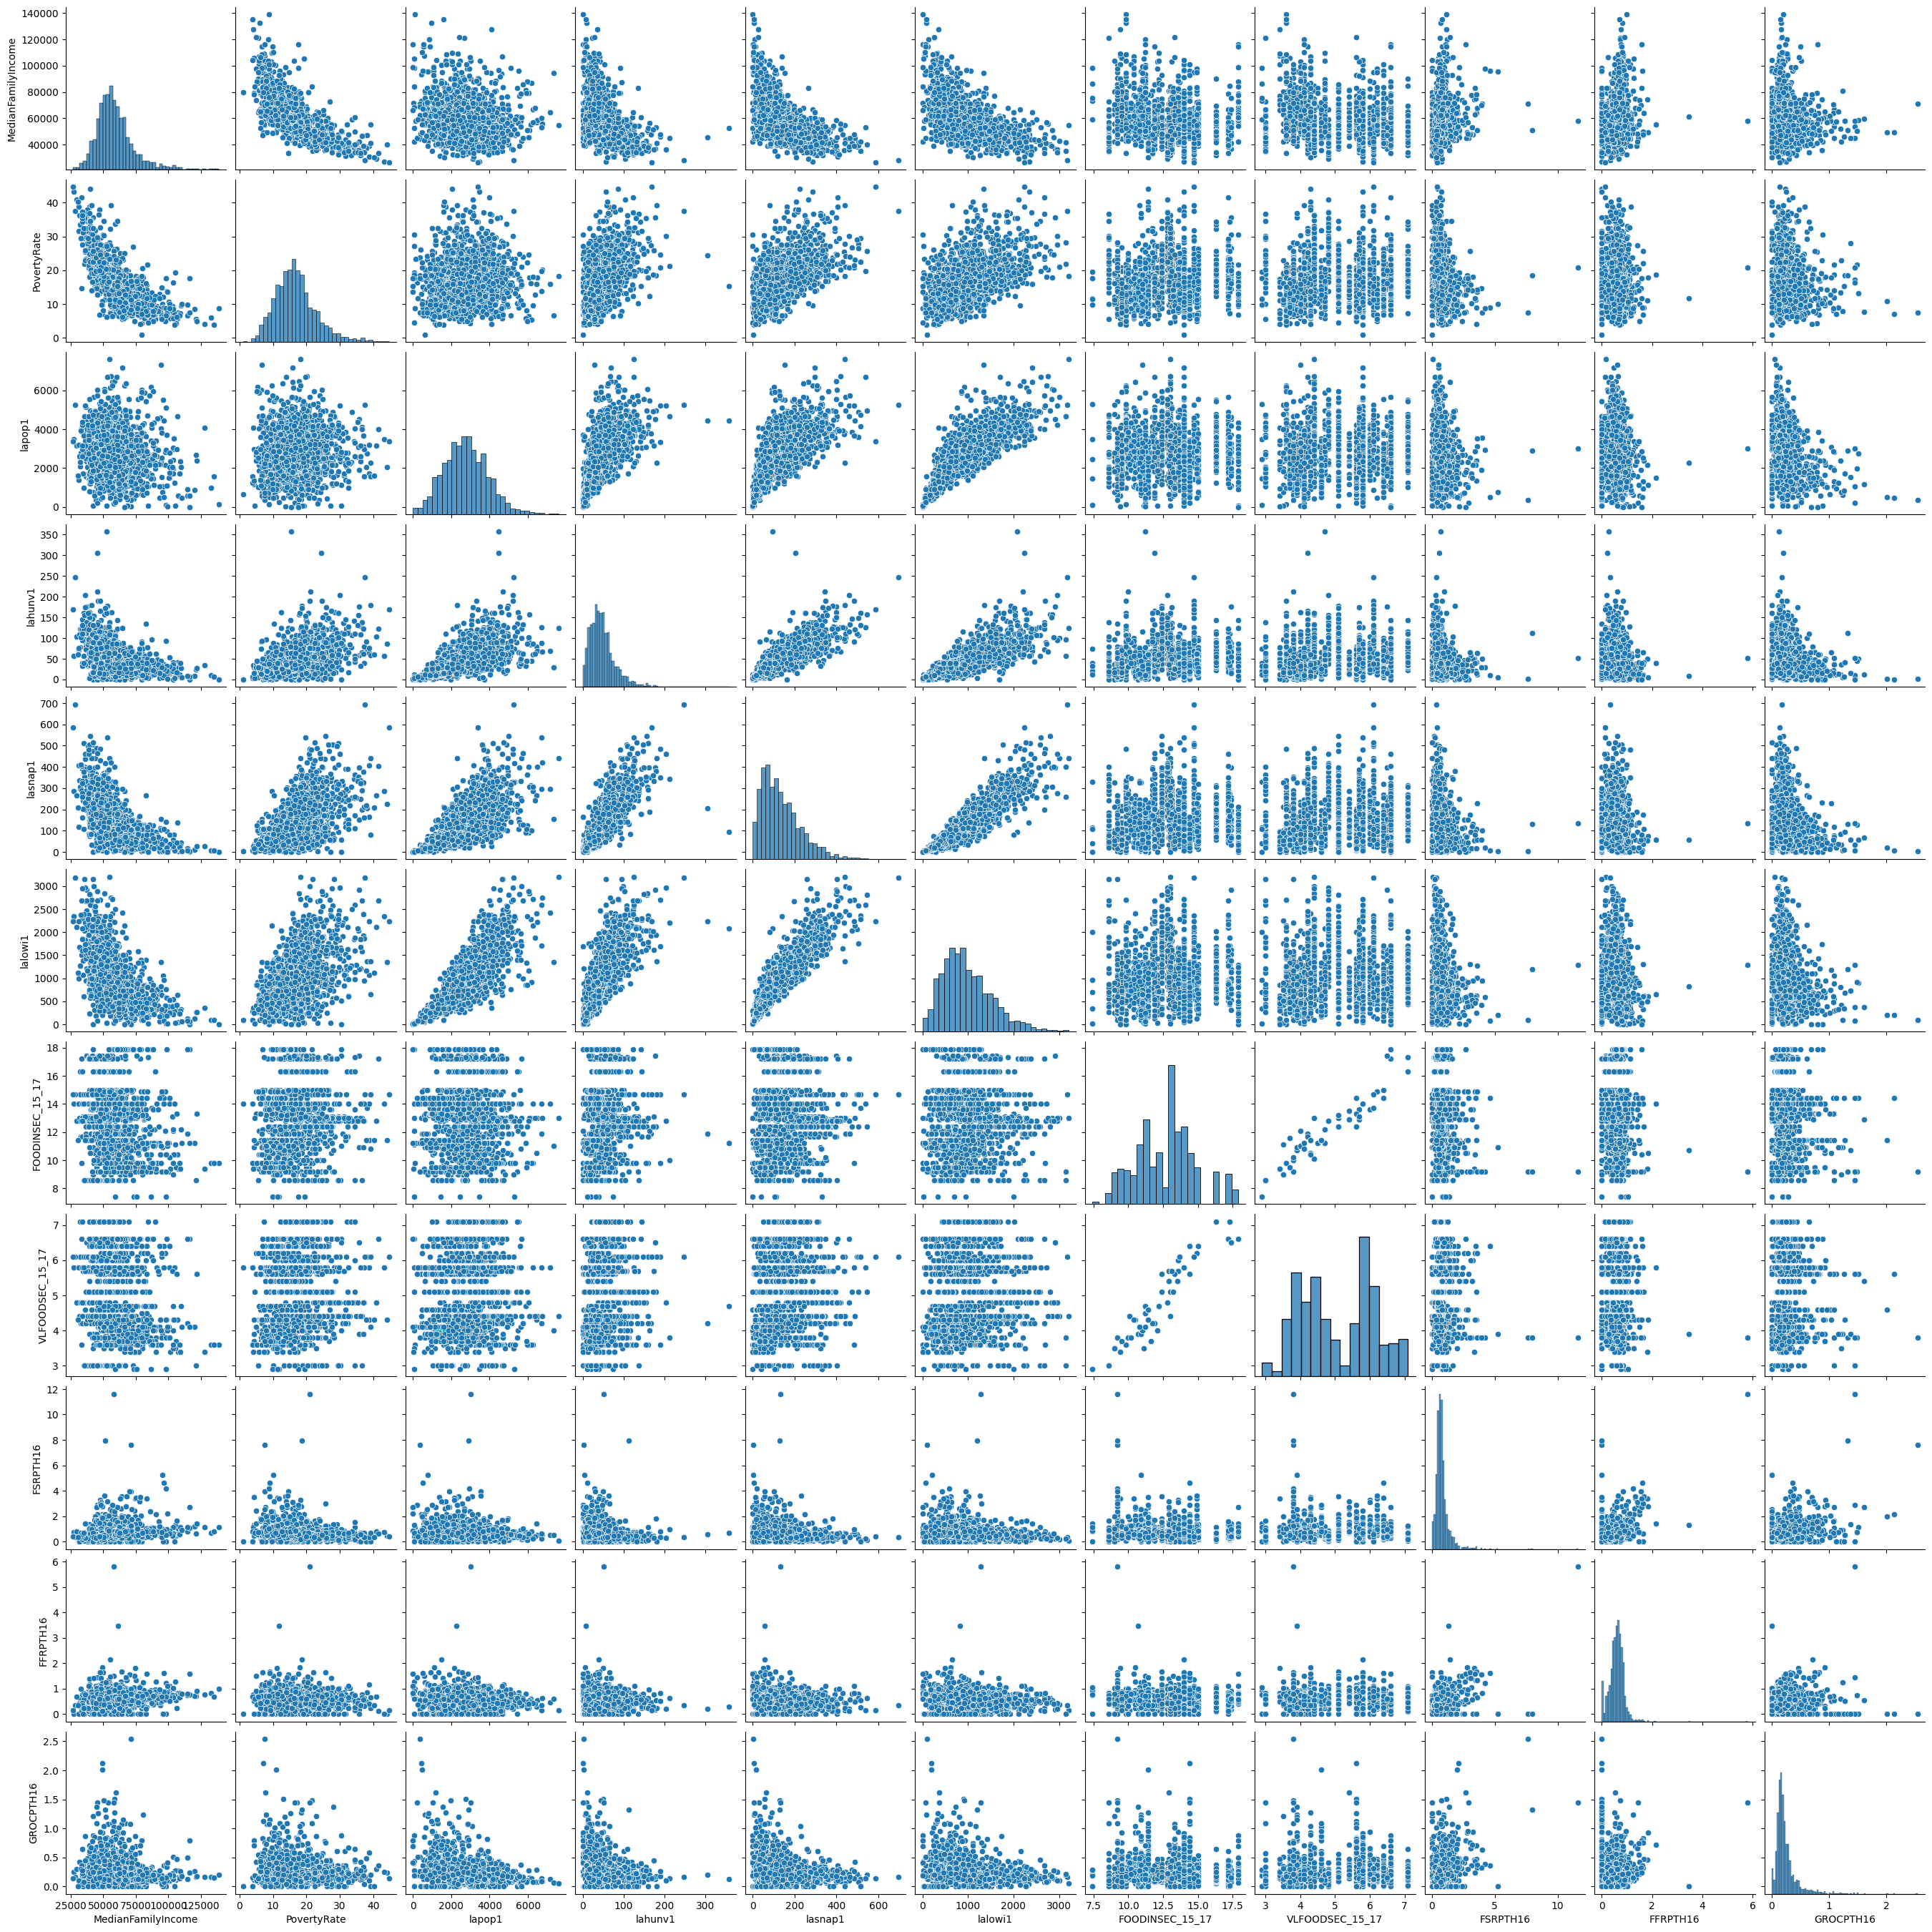

In [11]:
#Pairplot for 2015
sns.pairplot(dfclean15)

In [ ]:
### Principal component analysis for 2019

X19_low = dfclean19low[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
X_scaled1 = StandardScaler().fit_transform(X19_low)
pca1 = PCA(n_components=1)
dfclean19low.loc[:, 'access_index_pca'] = pca1.fit_transform(X_scaled1)

X19_lm = dfclean19lm[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
X_scaled2 = StandardScaler().fit_transform(X19_lm)
pca2 = PCA(n_components=1)
dfclean19lm.loc[:, 'access_index_pca'] = pca2.fit_transform(X_scaled2)

X19_um = dfclean19um[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
X_scaled3 = StandardScaler().fit_transform(X19_um)
pca3 = PCA(n_components=1)
dfclean19um.loc[:, 'access_index_pca'] = pca3.fit_transform(X_scaled3)

X19_h = dfclean19h[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
X_scaled4 = StandardScaler().fit_transform(X19_h)
pca4 = PCA(n_components=1)
dfclean19h.loc[:, 'access_index_pca'] = pca4.fit_transform(X_scaled4)


### PCA for 2015

X15_low = dfclean15low[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
X_scaled5 = StandardScaler().fit_transform(X15_low)
pca5 = PCA(n_components=1)
dfclean15low.loc[:, 'access_index_pca'] = pca5.fit_transform(X_scaled5)

X15_lm = dfclean15lm[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
X_scaled6 = StandardScaler().fit_transform(X15_lm)
pca6 = PCA(n_components=1)
dfclean15lm.loc[:, 'access_index_pca'] = pca6.fit_transform(X_scaled6)

X15_um = dfclean15um[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
X_scaled7 = StandardScaler().fit_transform(X15_um)
pca7 = PCA(n_components=1)
dfclean15um.loc[:, 'access_index_pca'] = pca7.fit_transform(X_scaled7) #to prevent error "A value is trying to be set on a copy of a slice"

X15_h = dfclean15h[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
X_scaled8 = StandardScaler().fit_transform(X15_h)
pca8 = PCA(n_components=1)
dfclean15h.loc[:, 'access_index_pca'] = pca8.fit_transform(X_scaled8)



C:\Users\GabeH\AppData\Local\Temp\ipykernel_86032\2245650079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean19low.loc[:, 'access_index_pca'] = pca1.fit_transform(X_scaled1)
C:\Users\GabeH\AppData\Local\Temp\ipykernel_86032\2245650079.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfclean19lm.loc[:, 'access_index_pca'] = pca2.fit_transform(X_scaled2)
C:\Users\GabeH\AppData\Local\Temp\ipykernel_86032\2245650079.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

MedianFamilyIncome  PovertyRate  ...   GROCPTH20  access_index_pca
count          396.000000   396.000000  ...  396.000000      3.960000e+02
mean         84263.660648    10.134758  ...    0.194638      6.280049e-17
std          14135.781084     3.477074  ...    0.118283      1.821173e+00
min          71085.443970     2.600000  ...    0.045617     -6.145589e+00
25%          74428.410353     7.983810  ...    0.141358     -1.239142e+00
50%          79076.724775     9.959562  ...    0.181765      4.952774e-01
75%          89733.256665    11.803026  ...    0.183694      9.641970e-01
max         176643.464564    37.544271  ...    1.199760      6.816369e+00

[8 rows x 12 columns]

In [ ]:
### CREATE LOADINGS FOR PLOTS

loadings19l = pd.DataFrame(
    pca1.components_.T, 
    index=X19_low.columns, 
    columns=['2019 lwo income loading']
)
print("Explained variance ratio for 2019 low income:", round(pca1.explained_variance_ratio_[0], 4))

loadings19lm = pd.DataFrame(
    pca2.components_.T, 
    index=X19_lm.columns, 
    columns=['2019 lower-middle income loading']
)
print("Explained variance ratio for 2019 lower-middle:", round(pca2.explained_variance_ratio_[0], 4))

loadings19um = pd.DataFrame(
    pca3.components_.T, 
    index=X19_um.columns, 
    columns=['2019 upper-middle income loading']
)
print("Explained variance ratio for 2019 upper-middle income:", round(pca3.explained_variance_ratio_[0], 4))

loadings19h = pd.DataFrame(
    pca4.components_.T, 
    index=X19_h.columns, 
    columns=['2019 high income loading']
)
print("Explained variance ratio for 2019 high income:", round(pca4.explained_variance_ratio_[0], 4))


loadings15l = pd.DataFrame(
    pca5.components_.T, 
    index=X15_low.columns, 
    columns=['2015 low income loading']
)

print("Explained variance ratio for 2015 low income:", round(pca5.explained_variance_ratio_[0], 4))


loadings15lm = pd.DataFrame(
    pca6.components_.T, 
    index=X15_lm.columns, 
    columns=['2015 lower-middle income loading']
)

print("Explained variance ratio for 2015 lower-middle income:", round(pca6.explained_variance_ratio_[0], 4))


loadings15um = pd.DataFrame(
    pca7.components_.T, 
    index=X15_um.columns, 
    columns=['2015 upper middle income loading']
)

print("Explained variance ratio for 2015 upper-middle income:", round(pca7.explained_variance_ratio_[0], 4))


loadings15h = pd.DataFrame(
    pca8.components_.T, 
    index=X15_h.columns, 
    columns=['2015 high income loading']
)

print("Explained variance ratio for 2015 high income:", round(pca8.explained_variance_ratio_[0], 4))




Explained variance ratio for 2019 low income: 0.3167
Explained variance ratio for 2019 lower-middle: 0.2984
Explained variance ratio for 2019 upper-middle income: 0.3396
Explained variance ratio for 2019 high income: 0.3008
Explained variance ratio for 2015 low income: 0.3693
Explained variance ratio for 2015 lower-middle income: 0.3272
Explained variance ratio for 2015 upper-middle income: 0.3442
Explained variance ratio for 2015 high income: 0.3315


In [16]:
#Plot loadings for 2015 and 2019
def plot1(ax):
    loadings19l.plot(kind='bar', legend=False, ax=ax)
    ax.set_title("PCA Feature Loadings 2019 low")
    ax.set_ylabel("Loading Weight")
    


def plot2(ax):
    loadings19lm.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2019 lower-middle")
    ax.set_ylabel("Loading Weight")
    

def plot3(ax):
    loadings19um.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2019 upper-middle")
    ax.set_ylabel("Loading Weight")
   

def plot4(ax):
    loadings19h.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2019 high")
    ax.set_ylabel("Loading Weight")
    

def plot5(ax):
    loadings15l.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2015 low")
    ax.set_ylabel("Loading Weight")
    

def plot6(ax):
    loadings15lm.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2015 lower-middle")
    ax.set_ylabel("Loading Weight")
    

def plot7(ax):
    loadings15um.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2015 upper-middle")
    ax.set_ylabel("Loading Weight")
    

def plot8(ax):
    loadings15h.plot(kind='bar', legend=False, ax = ax)
    ax.set_title("PCA Feature Loadings 2015 high")
    ax.set_ylabel("Loading Weight")


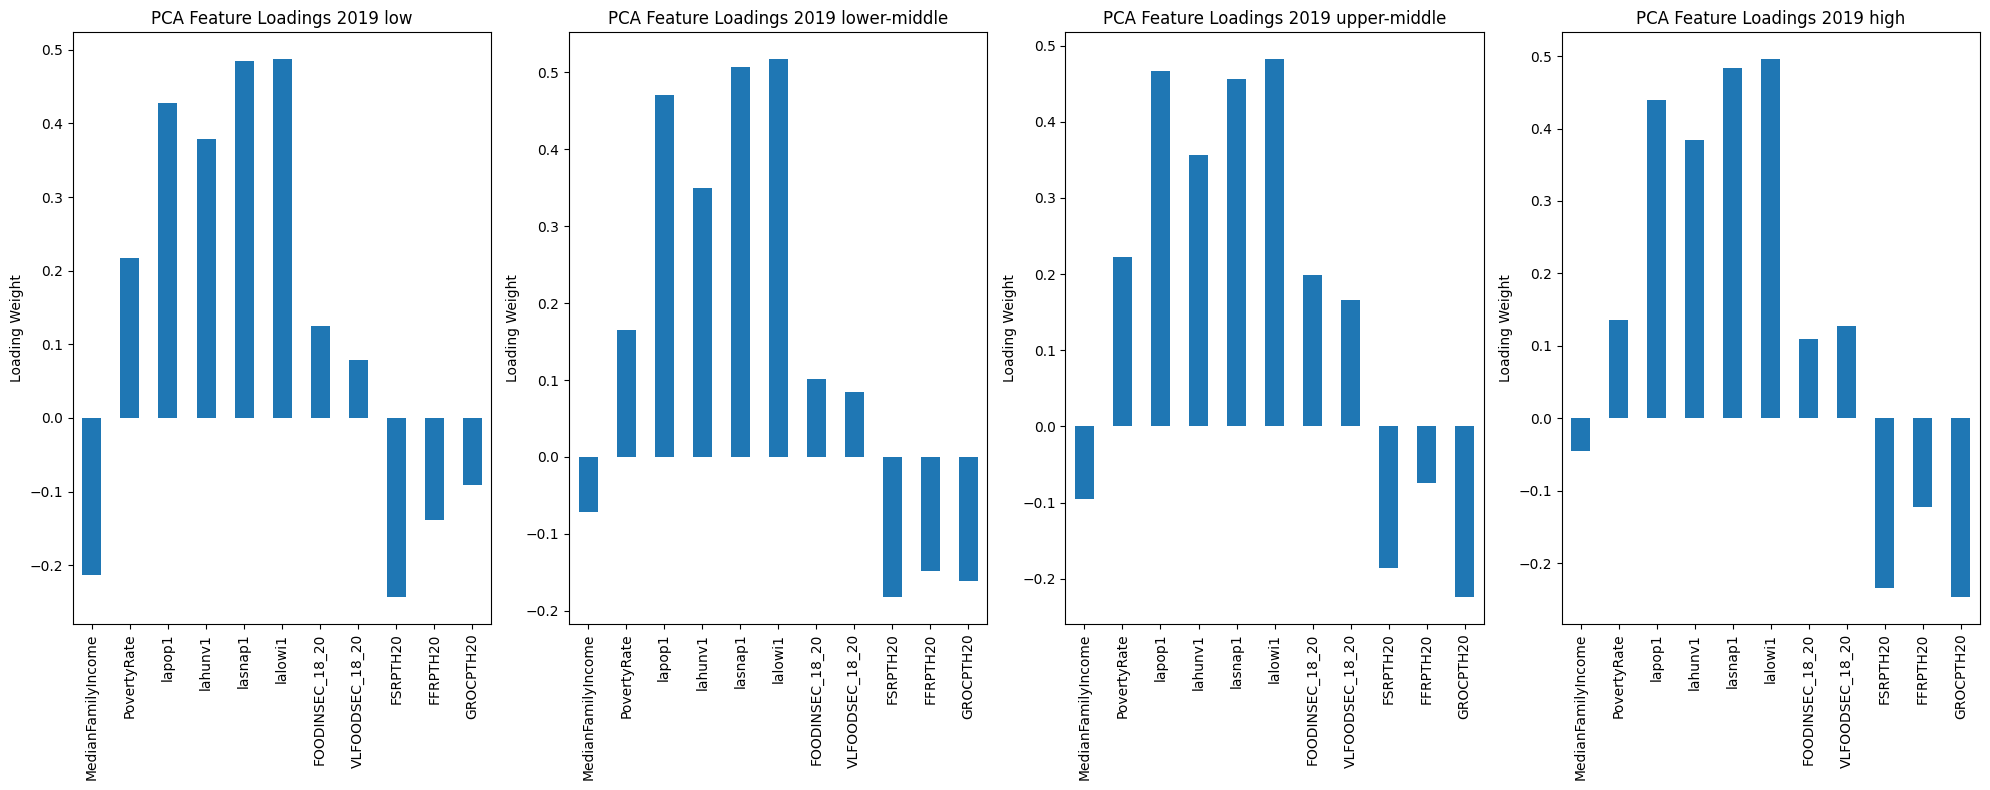

In [18]:
############  PCA 2019 VISUALIZATIONS BY INCOME

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes = axes.flatten()

# Top 4 plots
plot_functions_top = [plot1, plot2, plot3, plot4]
for ax, func in zip(axes, plot_functions_top):
    func(ax)


plt.tight_layout()
plt.show()

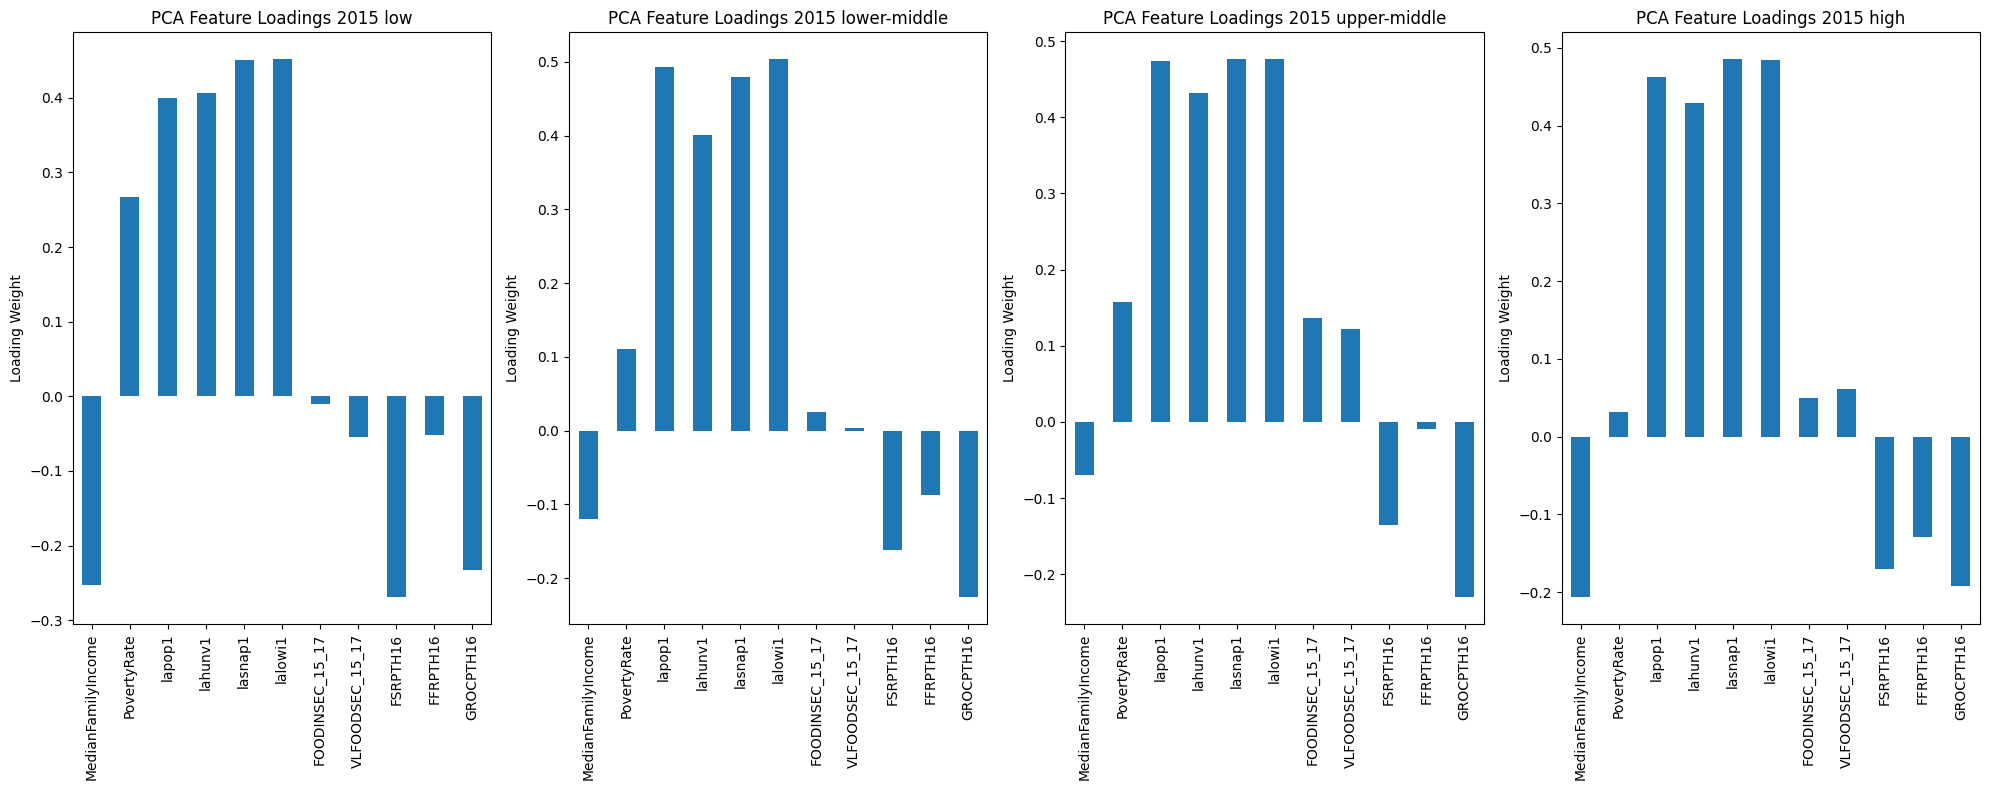

In [19]:
######PCA VISUALIZATIONS BY INCOME LEVEL

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes = axes.flatten()  # flatten to 1D array for easy indexing

plot_functions_bottom = [plot5, plot6, plot7, plot8]

# Loop through axes and functions
for ax, func in zip(axes, plot_functions_bottom):
    func(ax) 

plt.tight_layout()
plt.show()


In [ ]:




### What if we wanted to see how well our features are at predicting the number of low income people living at least one mile away from a supermarket?

X19l = dfclean19low[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
y19l = dfclean19low['lalowi1']

X19lm = dfclean19lm[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'FOODINSEC_18_20', 'lasnap1', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
y19lm = dfclean19lm['lalowi1']

X19um = dfclean19um[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
y19um = dfclean19um['lalowi1']

X19h = dfclean19h[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_18_20', 'VLFOODSEC_18_20', 'FSRPTH20', 'FFRPTH20', 'GROCPTH20']]
y19h = dfclean19h['lalowi1']

X15l = dfclean15low[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
y15l = dfclean15low['lalowi1']

X15lm = dfclean15lm[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
y15lm = dfclean15lm['lalowi1']

X15um = dfclean15um[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
y15um = dfclean15um['lalowi1']

X15h = dfclean15h[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'FOODINSEC_15_17', 'VLFOODSEC_15_17', 'FSRPTH16', 'FFRPTH16', 'GROCPTH16']]
y15h = dfclean15h['lalowi1']

In [51]:
### Train the models

model1 = LinearRegression()
X_train1, X_test1, y_train1, y_test1 = train_test_split(X19l, y19l, test_size=0.2, random_state=42)
model1.fit(X_train1, y_train1)

model2 = LinearRegression()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X19lm, y19lm, test_size=0.2, random_state=42)
model2.fit(X_train2, y_train2)


model3 = LinearRegression()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X19um, y19um, test_size=0.2, random_state=42)
model3.fit(X_train3, y_train3)

model4 = LinearRegression()
X_train4, X_test4, y_train4, y_test4 = train_test_split(X19h, y19h, test_size=0.2, random_state=42)
model4.fit(X_train4, y_train4)

model5 = LinearRegression()
X_train5, X_test5, y_train5, y_test5 = train_test_split(X15l, y15l, test_size=0.2, random_state=42)
model5.fit(X_train5, y_train5)

model6 = LinearRegression()
X_train6, X_test6, y_train6, y_test6 = train_test_split(X15lm, y15lm, test_size=0.2, random_state=42)
model6.fit(X_train6, y_train6)

model7 = LinearRegression()
X_train7, X_test7, y_train7, y_test7 = train_test_split(X15um, y15um, test_size=0.2, random_state=42)
model7.fit(X_train7, y_train7)

model8 = LinearRegression()
X_train8, X_test8, y_train8, y_test8 = train_test_split(X15h, y15h, test_size=0.2, random_state=42)
model8.fit(X_train8, y_train8)



LinearRegression()

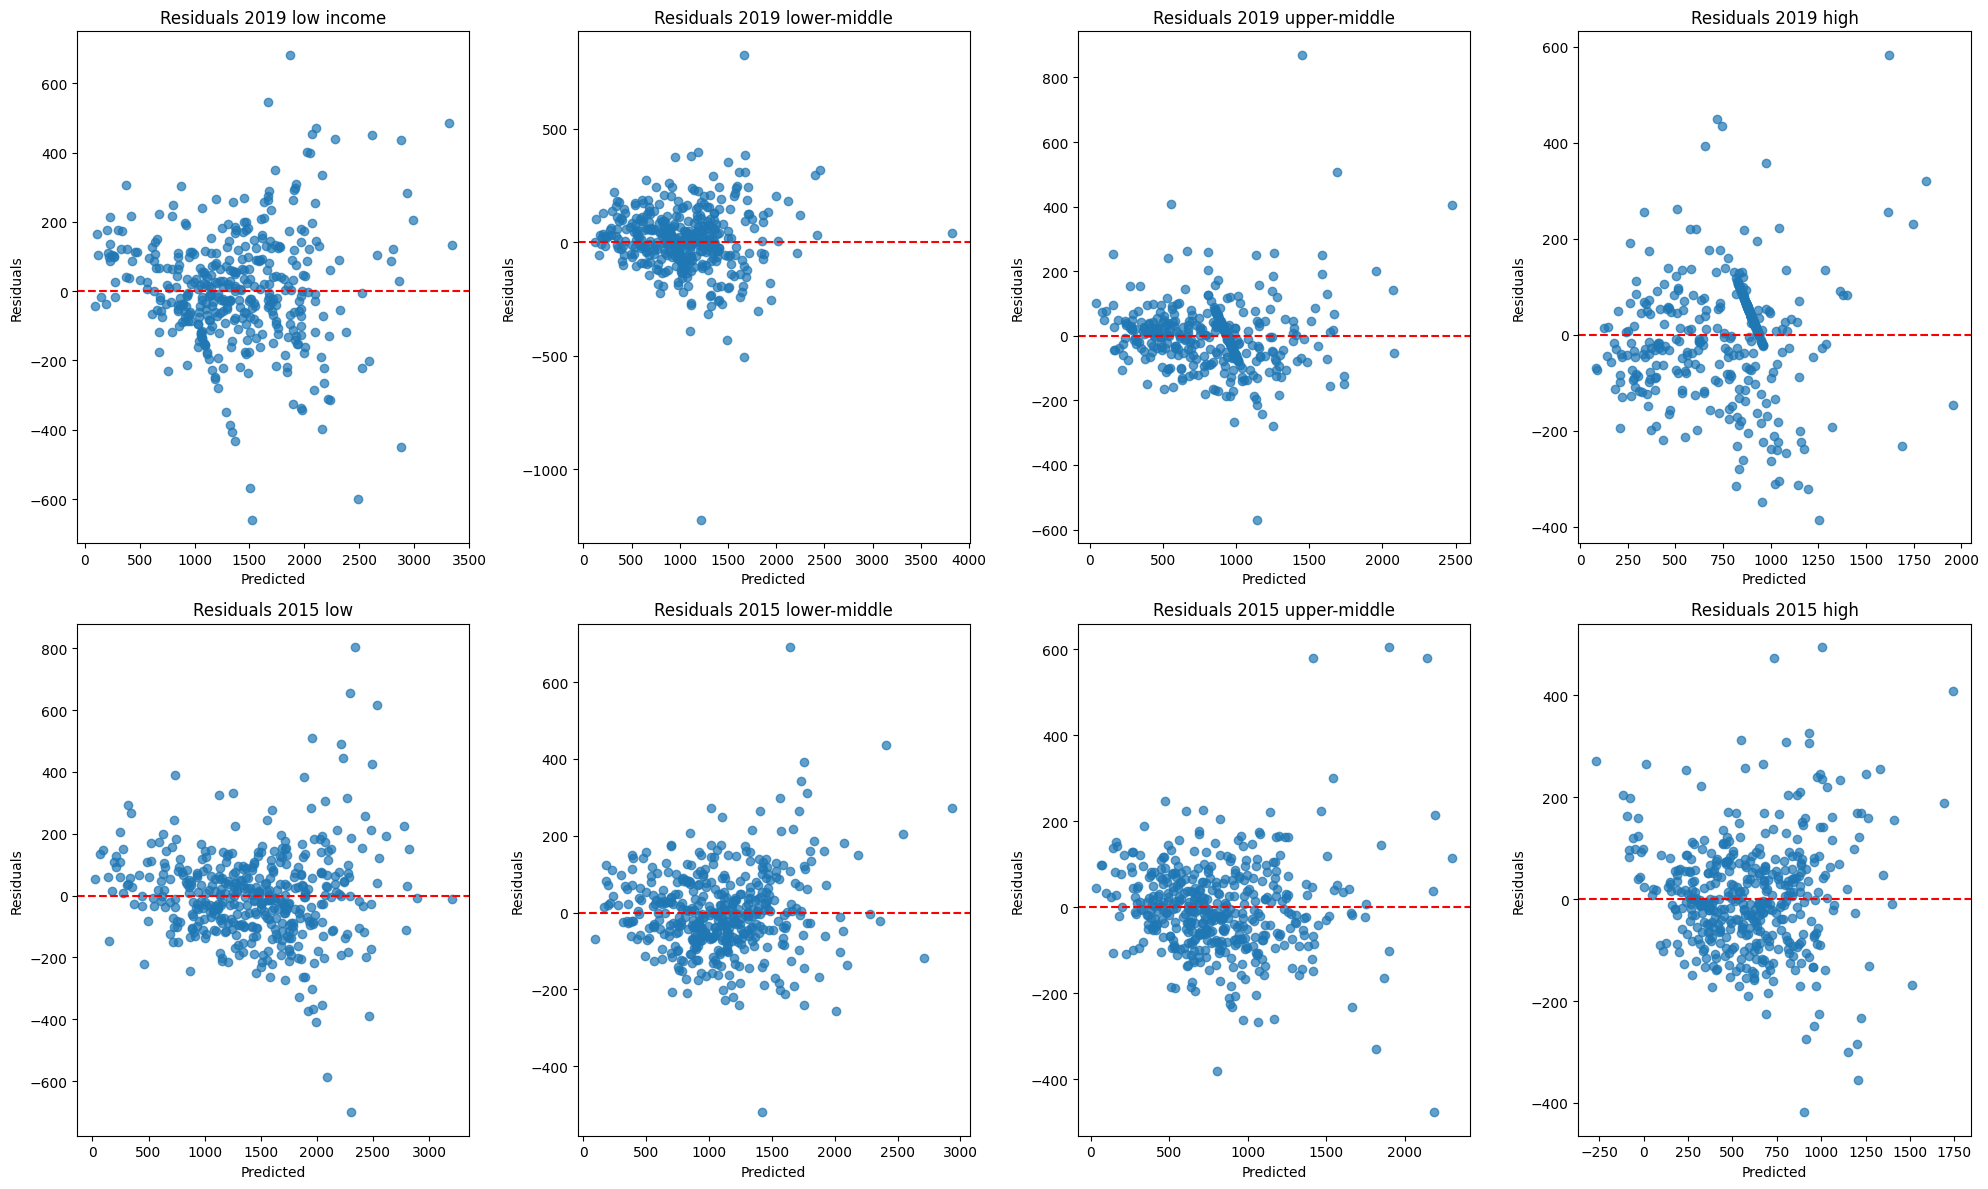

In [52]:
####Plot residuals for each LR model

def plot1(ax):
    pred = model1.predict(X19l)
    residuals = y19l - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2019 low income")
    
def plot2(ax):
    pred = model2.predict(X19lm)
    residuals = y19lm - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2019 lower-middle")

def plot3(ax):
    pred = model3.predict(X19um)
    residuals = y19um - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2019 upper-middle")

def plot4(ax):
    pred = model4.predict(X19h)
    residuals = y19h - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2019 high")

def plot5(ax):
    pred = model5.predict(X15l)
    residuals = y15l - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2015 low")

def plot6(ax):
    pred = model6.predict(X15lm)
    residuals = y15lm - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2015 lower-middle")

def plot7(ax):
    pred = model7.predict(X15um)
    residuals = y15um - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2015 upper-middle")

def plot8(ax):
    pred = model8.predict(X15h)
    residuals = y15h - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals 2015 high")


fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()  # flatten to 1D array for easy indexing

plot_functions = [plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8]

# Loop through axes and functions
for ax, func in zip(axes, plot_functions):
    func(ax) 

plt.tight_layout()
plt.show()

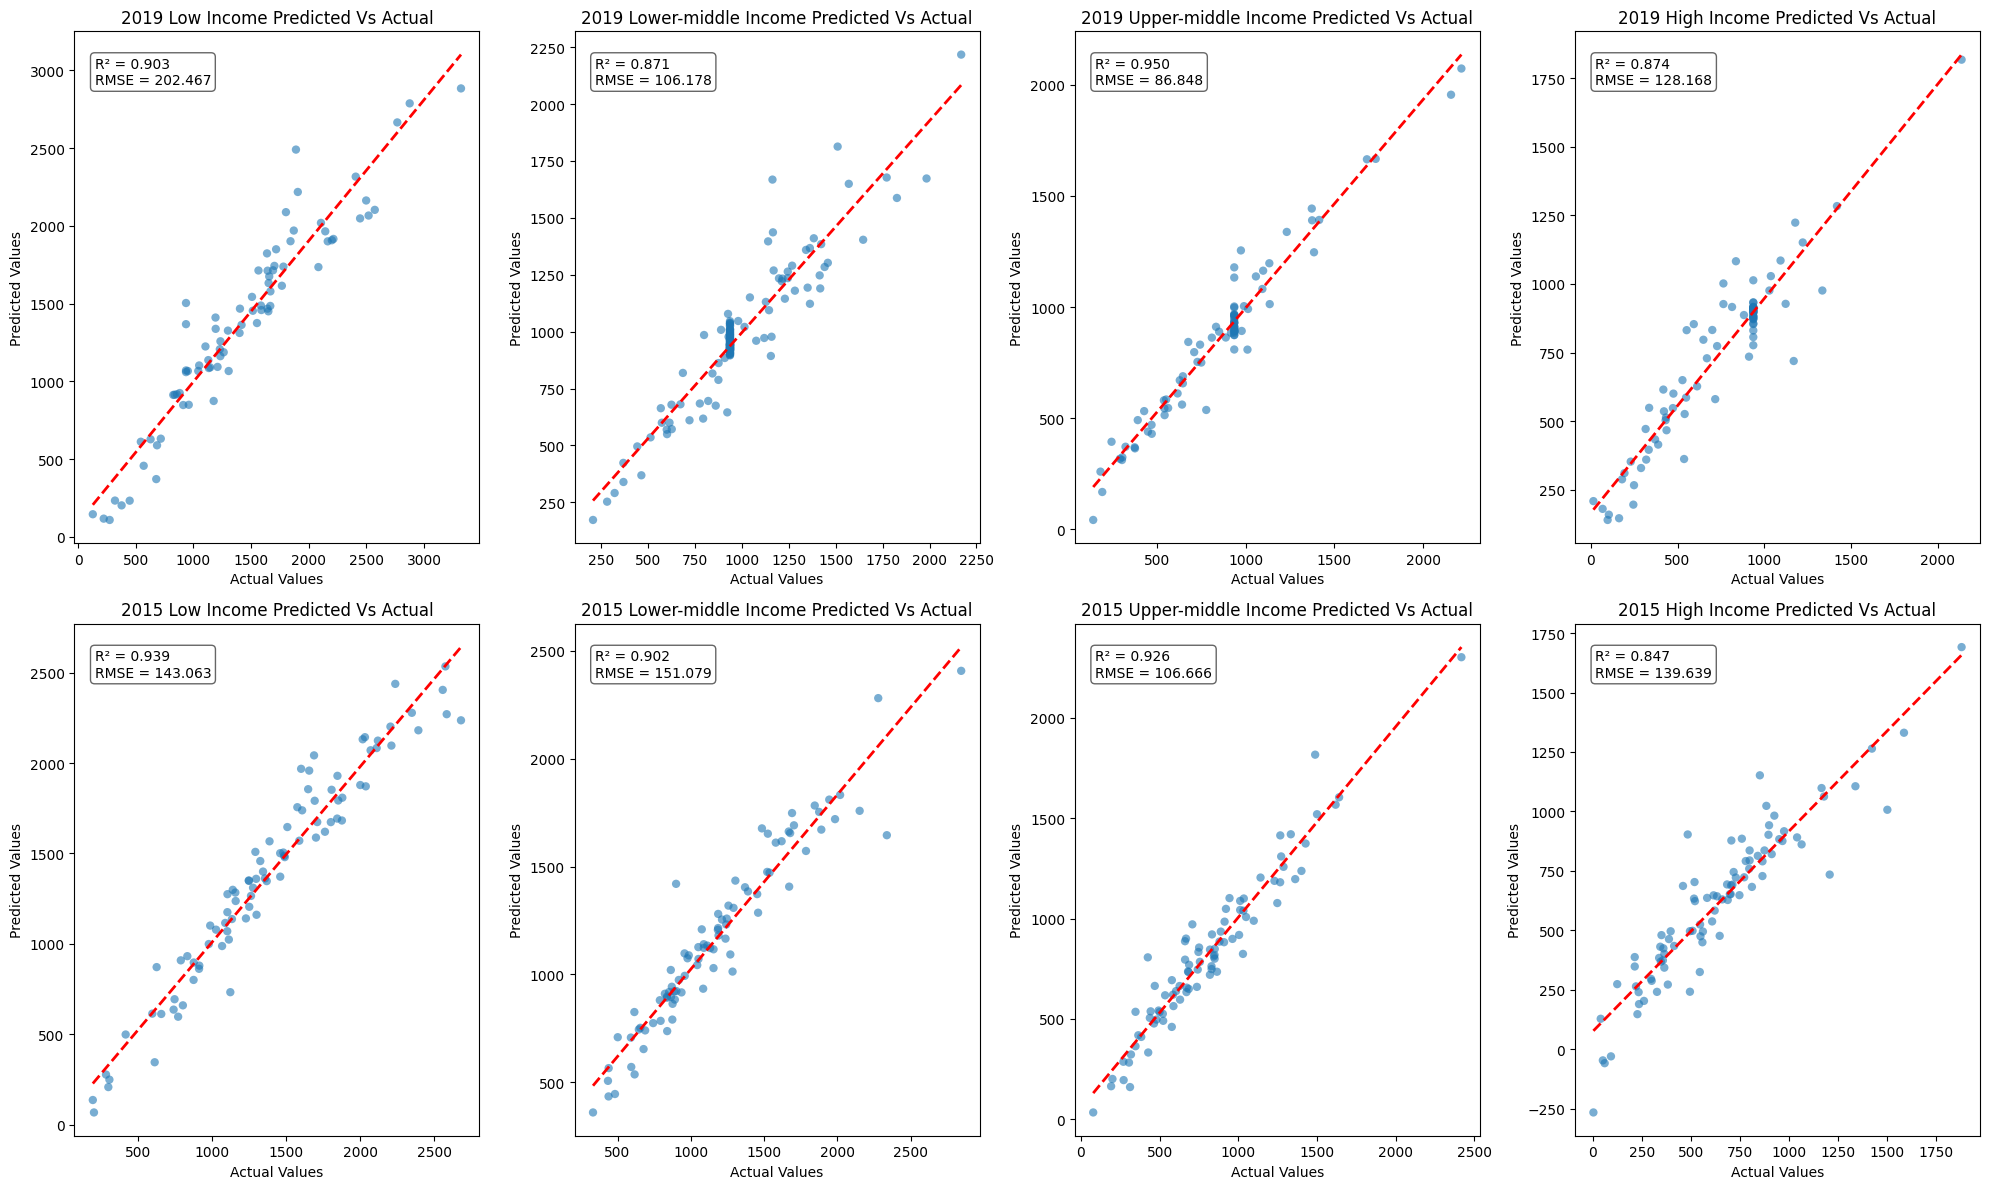

In [25]:
#### PLOT PREDICTED VS ACTUAL
def plotm(ax, model, X_test, y_test, title):
    pred = model.predict(X_test)
    
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    # Scatter
    ax.scatter(y_test, pred, alpha=0.6, edgecolor = 'none')
    
    # Regression line
    m, b = np.polyfit(y_test, pred, 1)
    x_vals = np.linspace(y_test.min(), y_test.max(), 100)
    ax.plot(x_vals, m*x_vals + b, "r--", linewidth=2)
    
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{title + " Income Predicted Vs Actual"}")

    ax.text(
        0.05, 0.95,
        f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
        transform=ax.transAxes,
        verticalalignment='top',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6)
    )

plot_info = [
    {"model": model1, "X": X_test1, "y": y_test1, "title": "2019 Low"},
    {"model": model2, "X": X_test2, "y": y_test2, "title": "2019 Lower-middle"},
    {"model": model3, "X": X_test3, "y": y_test3, "title": "2019 Upper-middle"},
    {"model": model4, "X": X_test4, "y": y_test4, "title": "2019 High"},

    {"model": model5, "X": X_test5, "y": y_test5, "title": "2015 Low"},
    {"model": model6, "X": X_test6, "y": y_test6, "title": "2015 Lower-middle"},
    {"model": model7, "X": X_test7, "y": y_test7, "title": "2015 Upper-middle"},
    {"model": model8, "X": X_test8, "y": y_test8, "title": "2015 High"}
]

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for ax, item in zip(axes, plot_info):
    plotm(ax, item["model"], item["X"], item["y"], item["title"])

plt.tight_layout()
plt.show()

Our features are a good predictor for the number of low income people living at least one mile away from a supermarket.

Back to the main research question at hand. Since we are interested in identifying whether a difference in supermarket accessibility exists, we must compute the difference between 2019 and 2015 for all features. Essentially a delta dataframe for each income group. The statistic we are interested in is the pca index for each income group from 2019 minus the pca index for each income group from 2015, or the delta accessibility index.  This allows us to set up our hypotheses for a one sample t-test for each income group, so we will have four p values. 
H0: delta accessibility is equal to zero
H1: delta accessibility is not equal to zero

In [ ]:
##  Create delta dataframes 

rmlist19 = ['County', 'IncomeGroup', 'FFRPTH20', 'FOODINSEC_18_20', 'FSRPTH20', 'GROCPTH20', 'VLFOODSEC_18_20']
rmlist15 = ['County', 'IncomeGroup', 'FFRPTH16', 'FOODINSEC_15_17', 'FSRPTH16', 'GROCPTH16', 'VLFOODSEC_15_17']

ddfclean19low = dfclean19low.copy()
ddfclean15low = dfclean15low.copy()
ddfclean15low = ddfclean15low[ddfclean15low['County'].isin(ddfclean19low['County'])] #Match counties accross 2015 and 2019, sort them, then take the difference because at they point the dfs will be exact
ddfclean19low = ddfclean19low[ddfclean19low['County'].isin(ddfclean15low['County'])]
ddfclean15low = ddfclean15low.sort_values("County").reset_index(drop=True)
ddfclean19low = ddfclean19low.sort_values("County").reset_index(drop=True)
ddfclean19low = ddfclean19low.drop(rmlist19, axis = 1)
ddfclean15low = ddfclean15low.drop(rmlist15, axis = 1)

ddfclean19lm = dfclean19lm.copy()
ddfclean15lm = dfclean15lm.copy()
ddfclean15lm = ddfclean15lm[ddfclean15lm['County'].isin(ddfclean19lm['County'])] #Match counties accross 2015 and 2019, sort them, then take the difference because at they point the dfs will be exact
ddfclean19lm = ddfclean19lm[ddfclean19lm['County'].isin(ddfclean15lm['County'])]
ddfclean15lm = ddfclean15lm.sort_values("County").reset_index(drop=True)
ddfclean19lm = ddfclean19lm.sort_values("County").reset_index(drop=True)
ddfclean19lm = ddfclean19lm.drop(rmlist19, axis = 1)
ddfclean15lm = ddfclean15lm.drop(rmlist15, axis = 1)

ddfclean19um = dfclean19um.copy()
ddfclean15um = dfclean15um.copy()
ddfclean15um = ddfclean15um[ddfclean15um['County'].isin(ddfclean19um['County'])] #Match counties accross 2015 and 2019, sort them, then take the difference because at they point the dfs will be exact
ddfclean19um = ddfclean19um[ddfclean19um['County'].isin(ddfclean15um['County'])]
ddfclean15um = ddfclean15um.sort_values("County").reset_index(drop=True)
ddfclean19um = ddfclean19um.sort_values("County").reset_index(drop=True)
ddfclean19um = ddfclean19um.drop(rmlist19, axis = 1)
ddfclean15um = ddfclean15um.drop(rmlist15, axis = 1)

ddfclean19h = dfclean19h.copy()
ddfclean15h = dfclean15h.copy()
ddfclean15h = ddfclean15h[ddfclean15h['County'].isin(ddfclean19h['County'])] #Match counties accross 2015 and 2019, sort them, then take the difference because at they point the dfs will be exact
ddfclean19h = ddfclean19h[ddfclean19h['County'].isin(ddfclean15h['County'])]
ddfclean15h = ddfclean15h.sort_values("County").reset_index(drop=True)
ddfclean19h = ddfclean19h.sort_values("County").reset_index(drop=True)
ddfclean19h = ddfclean19h.drop(rmlist19, axis = 1)
ddfclean15h = ddfclean15h.drop(rmlist15, axis = 1)

dfdeltal = ddfclean19low - ddfclean15low 
dfdeltalm = ddfclean19lm - ddfclean15lm 
dfdeltaum = ddfclean19um - ddfclean15um 
dfdeltah = ddfclean19h - ddfclean15h 


After identifying that a difference in accessibility does exist, we can now use linear regression to determine why a difference exists. Performing a coefficient analysis on the remaining features will tell us how they changed from 2015 to 2019. 

In [ ]:
### Set up independent and dependent variables

Xd1 = dfdeltal[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']]
yd1 = dfdeltal['access_index_pca']

Xd2 = dfdeltalm[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']]
yd2 = dfdeltalm['access_index_pca']

Xd3 = dfdeltaum[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']]
yd3 = dfdeltaum['access_index_pca']

Xd4 = dfdeltah[['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']]
yd4 = dfdeltah['access_index_pca']

In [ ]:
### Start model training

model1 = LinearRegression()
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xd1, yd1, test_size=0.2, random_state=42)
model1.fit(X_train1, y_train1)

model2 = LinearRegression()
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xd2, yd2, test_size=0.2, random_state=42)
model2.fit(X_train2, y_train2)


model3 = LinearRegression()
X_train3, X_test3, y_train3, y_test3 = train_test_split(Xd3, yd3, test_size=0.2, random_state=42)
model3.fit(X_train3, y_train3)

model4 = LinearRegression()
X_train4, X_test4, y_train4, y_test4 = train_test_split(Xd4, yd4, test_size=0.2, random_state=42)
model4.fit(X_train4, y_train4)


LinearRegression()

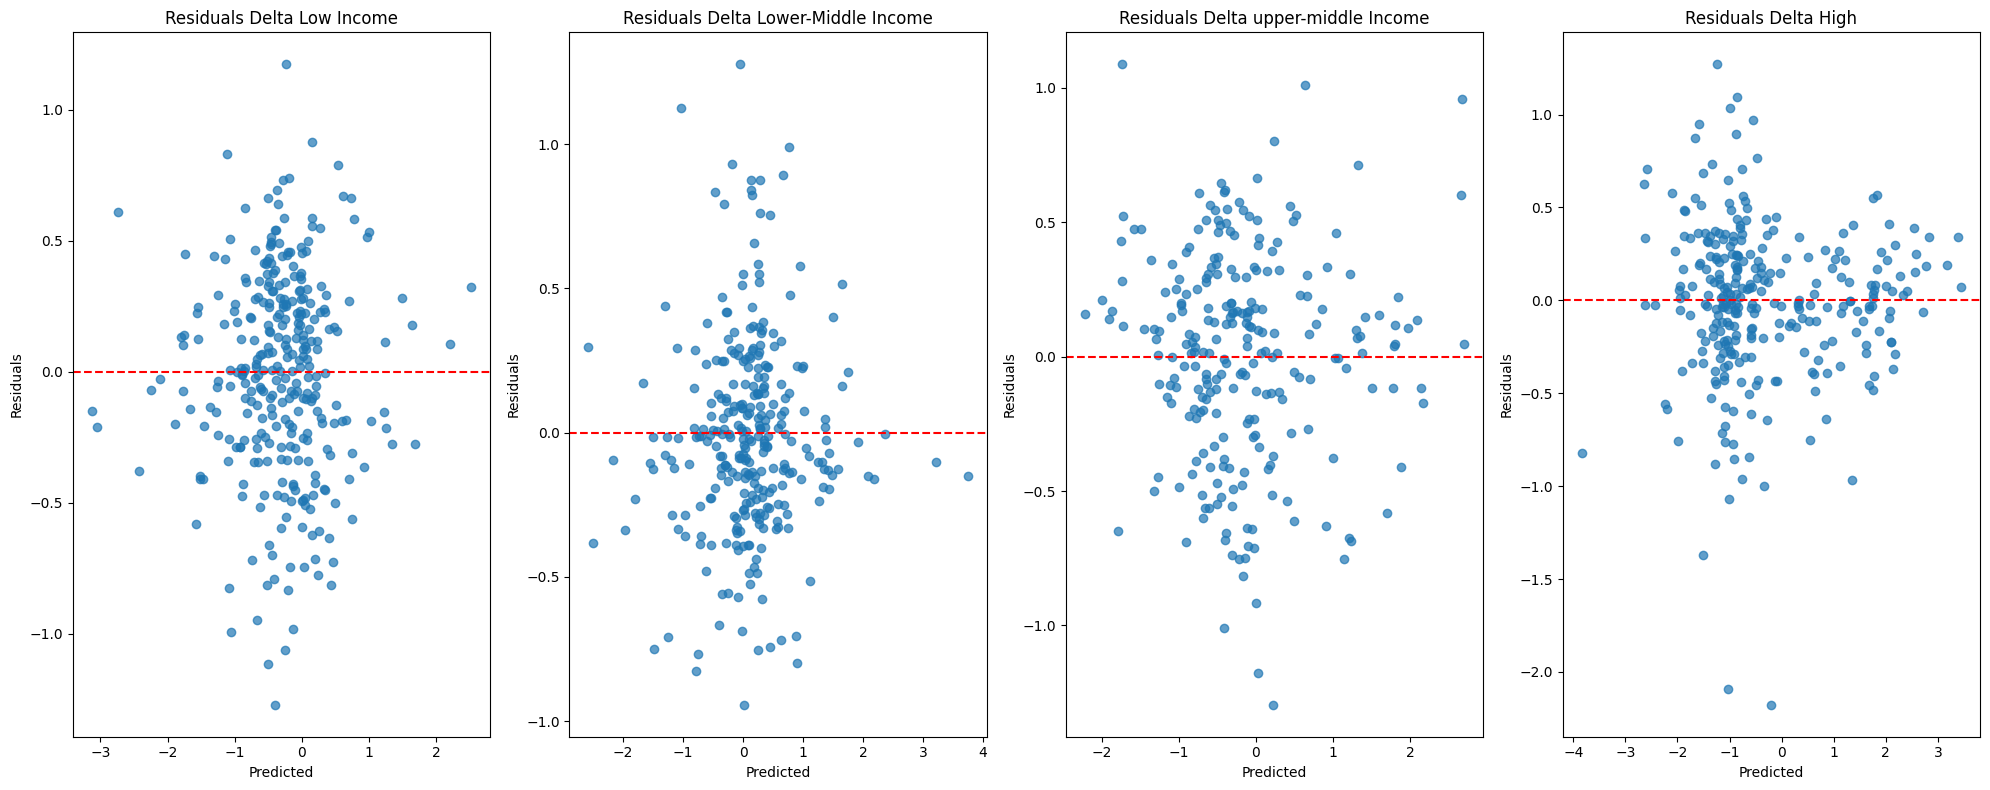

In [ ]:
##Plot residuals

def plot1(ax):
    pred = model1.predict(Xd1)
    residuals = yd1 - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals Delta Low Income")
    
def plot2(ax):
    pred = model2.predict(Xd2)
    residuals = yd2 - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals Delta Lower-Middle Income")

def plot3(ax):
    pred = model3.predict(Xd3)
    residuals = yd3 - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals Delta upper-middle Income")

def plot4(ax):
    pred = model4.predict(Xd4)
    residuals = yd4 - pred

    ax.scatter(pred, residuals, alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residuals")
    ax.set_title("Residuals Delta High")


fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes = axes.flatten()  # flatten to 1D array for easy indexing

plot_functions = [plot1, plot2, plot3, plot4]

# Loop through axes and functions
for ax, func in zip(axes, plot_functions):
    func(ax) 

plt.tight_layout()
plt.show()

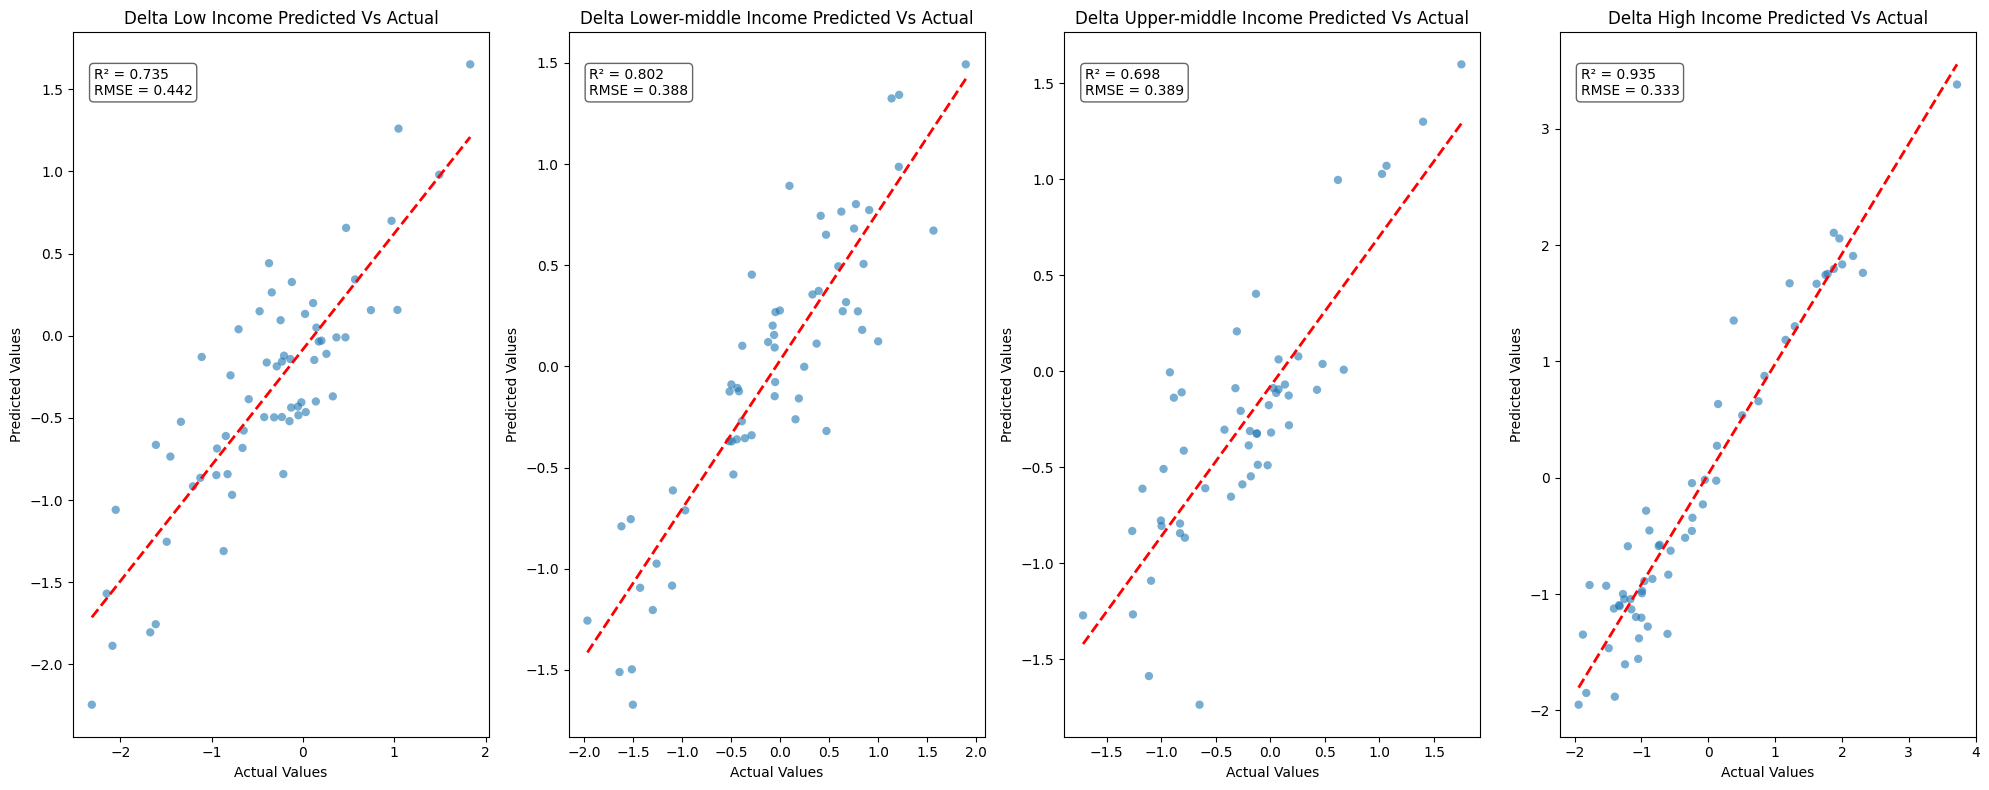

In [ ]:
### Predicted vs Actual delta residuals

def plotm(ax, model, X_test, y_test, title):
    pred = model.predict(X_test)
    
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    # Scatter
    ax.scatter(y_test, pred, alpha=0.6, edgecolor = 'none')
    
    # Regression line
    m, b = np.polyfit(y_test, pred, 1)
    x_vals = np.linspace(y_test.min(), y_test.max(), 100)
    ax.plot(x_vals, m*x_vals + b, "r--", linewidth=2)
    
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{title + " Predicted Vs Actual"}")

    ax.text(
        0.05, 0.95,
        f"R² = {r2:.3f}\nRMSE = {rmse:.3f}",
        transform=ax.transAxes,
        verticalalignment='top',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6)
    )

plot_info = [
    {"model": model1, "X": X_test1, "y": y_test1, "title": "Delta Low Income"},
    {"model": model2, "X": X_test2, "y": y_test2, "title": "Delta Lower-middle Income"},
    {"model": model3, "X": X_test3, "y": y_test3, "title": "Delta Upper-middle Income"},
    {"model": model4, "X": X_test4, "y": y_test4, "title": "Delta High Income"}
]

fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes = axes.flatten()

for ax, item in zip(axes, plot_info):
    plotm(ax, item["model"], item["X"], item["y"], item["title"])

plt.tight_layout()
plt.show()

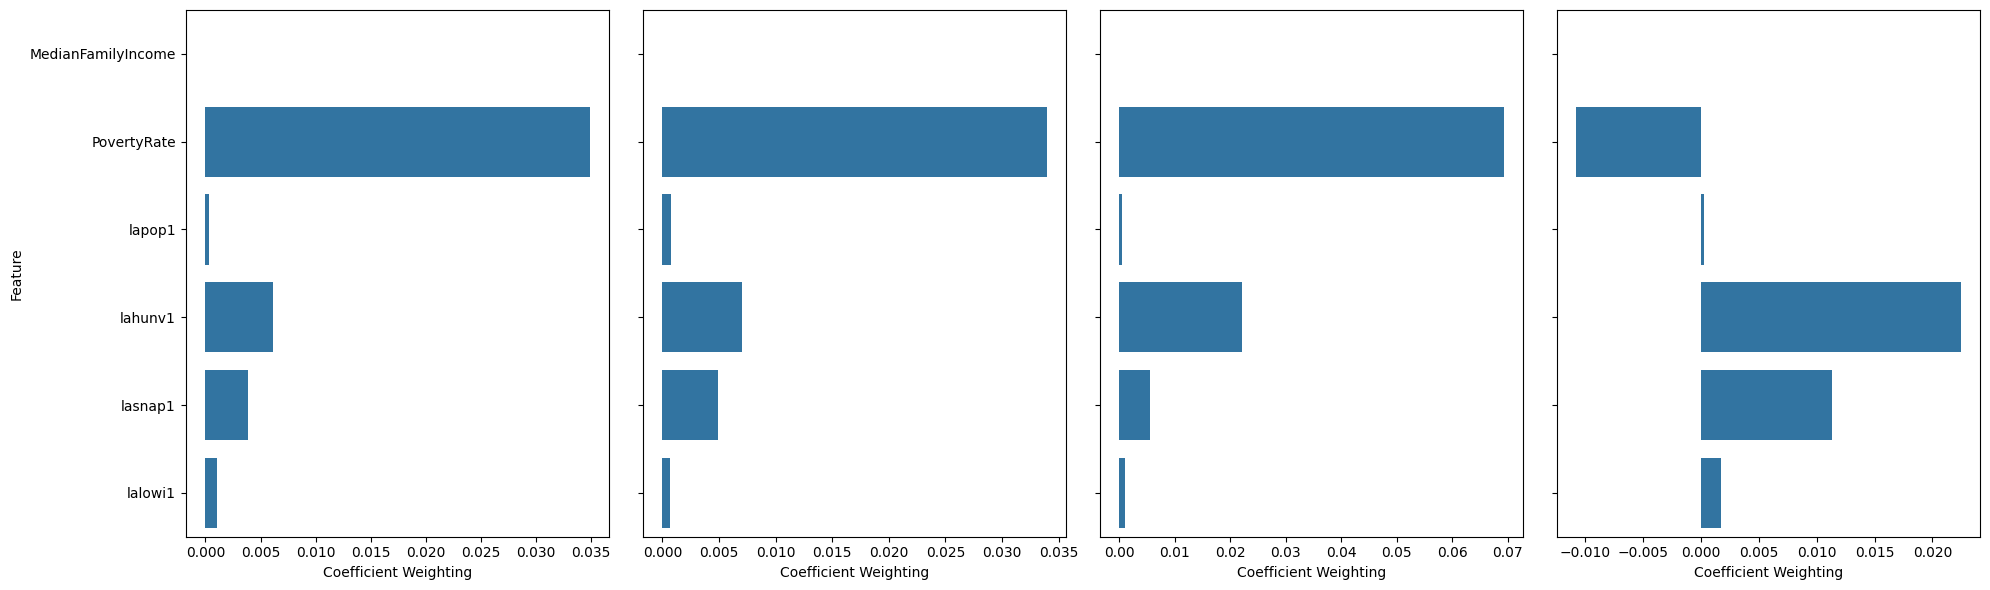

In [ ]:
## Create barplots for coefficient analysis

dfdeltalc = pd.DataFrame()
dfdeltalc['Coefficient Weighting'] = model1.coef_
dfdeltalc['Feature'] = ['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']

dfdeltalmc = pd.DataFrame()
dfdeltalmc['Coefficient Weighting'] = model2.coef_
dfdeltalmc['Feature'] = ['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']

dfdeltaumc = pd.DataFrame()
dfdeltaumc['Coefficient Weighting'] = model3.coef_
dfdeltaumc['Feature'] = ['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']

dfdeltahc = pd.DataFrame()
dfdeltahc['Coefficient Weighting'] = model4.coef_
dfdeltahc['Feature'] = ['MedianFamilyIncome', 'PovertyRate', 'lapop1', 'lahunv1', 'lasnap1', 'lalowi1']



fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

dfs   = [dfdeltalc, dfdeltalmc, dfdeltaumc, dfdeltahc]
titles = ["Delta Low Income", "Delta Lower-Middle Income", "Delta Upper-Middle Income", "Delta High Income"]

for ax, df, title in zip(axes, dfs, titles):
    sns.barplot(x="Coefficient Weighting", y="Feature", data=df, ax=ax)

plt.tight_layout()
plt.show()

Analyzing the horizontal bar chart, the median family income coefficient weighting is approximately zero for all delta dataframes, meaning there is not a significant enough difference in income in 2019 vs 2015 to explain if the change in income led to the change in supermarket accessibility in 2019 vs 2015. The poverty rate in 2019 was higher than in 2015. As the median family income level increases, the low access feature weightings decline. There is minimal difference between low and lower-middle, but there is a drastic difference in the effect poverty, the number of people without a vehicle living at least one mile away from a supermarket, the number of people living at least one mile away from a supermarket on SNAP benefits, and the number of low income people living at least one mile away from a supermarket had on the overall change in supermarket accessibility in 2019 vs 2015.